# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — количество недвижимости у клиента

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата

Целевой признак

Exited — факт ухода клиента

# 1. Подготовка данных

In [120]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import warnings
from sklearn.metrics import mean_squared_error

In [121]:
warnings.filterwarnings('ignore')

In [122]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [123]:
data.shape

(10000, 14)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [125]:
data_ohe = pd.get_dummies(data, columns = ['Geography', 'Gender'],  drop_first=True)
#Ввел дамми переменные для категориальных признаков, опуская один из каждой группы для избежания дамми-ловушки. 

#Построим тут модель регрессии случайного леса для заполенения пропусков. Обучающей выборкой будут та часть данных, где нет пропусков. В признаки не включу факт ухода клиента - это будет целевой признак в основном исследование. 

In [126]:
data_filtered = data_ohe.loc[~data['Tenure'].isna()]

In [127]:
train_target, valid_target = train_test_split(data_ohe.loc[~data['Tenure'].isna(), 'Tenure'], 
                                              test_size = 0.25, random_state = 12345)
train_features, valid_features = train_test_split(data_ohe.loc[~data['Tenure'].isna()].drop(columns = 
                                                                ['Exited', 'RowNumber', 'CustomerId', 'Surname', 'Tenure']),
                                                test_size = 0.25, random_state = 12345)
tofind_target = data_ohe.loc[data['Tenure'].isna(), 'Tenure']
tofind_features = data_ohe.loc[data['Tenure'].isna()].drop(columns = 
                                                                ['Exited', 'RowNumber', 'CustomerId', 'Surname', 'Tenure'])

In [128]:
model = RandomForestRegressor(n_estimators = 20, max_depth = 20, random_state = 12345)
model.fit(train_features, train_target)
valid_predictions = model.predict(valid_features).round()
mse = mean_squared_error(valid_target, valid_predictions)
rmse = mse ** 0.5
print(rmse)

2.959694042522125


In [129]:
predictions = model.predict(tofind_features).round()

In [130]:
data_ohe.loc[data['Tenure'].isna(), 'Tenure'] = predictions

In [131]:
target = data_ohe['Exited']
features = data_ohe.drop(columns = ['Exited', 'RowNumber', 'CustomerId', 'Surname'])
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size = 0.2, 
                                                                              random_state = 12345)
train_features, test_features, train_target, test_target = train_test_split(train_features, train_target, test_size = 0.25, 
                                                                              random_state = 12345)


In [132]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

#Присустствует дисбаланс классов, что отрицательно скажется на обучении моедели, но в начале исследования не будем обращать на это внимание и обучим модели без учета этого дисбаланса. 

# 2. Исследование задачи

# Решающее дерево

In [133]:
def tree(start, stop, learn_features, learn_target, features, target):
    for i in range(start, stop):   
        model = DecisionTreeClassifier(max_depth = i, random_state = 12345)
        model.fit(learn_features, learn_target)
        valid_predictions = model.predict(features)
        probabilities_valid = model.predict_proba(features)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target, probabilities_one_valid)
        print('Глубина дерева' , str(i), 'f1-мера' , str(f1_score(target, valid_predictions)), 'AUC_ROC', str(auc_roc))

In [134]:
tree(3, 10, train_features, train_target, valid_features, valid_target)

Глубина дерева 3 f1-мера 0.4113475177304965 AUC_ROC 0.8100922922085365
Глубина дерева 4 f1-мера 0.42456140350877186 AUC_ROC 0.8260800302529065
Глубина дерева 5 f1-мера 0.5608011444921316 AUC_ROC 0.8468610376210971
Глубина дерева 6 f1-мера 0.5096153846153846 AUC_ROC 0.8438000151860062
Глубина дерева 7 f1-мера 0.5565217391304348 AUC_ROC 0.836246465903694
Глубина дерева 8 f1-мера 0.552112676056338 AUC_ROC 0.8198656782859466
Глубина дерева 9 f1-мера 0.5344352617079889 AUC_ROC 0.7746381785129923


#Решающие деревья различной глубины не достигают порогового значения f1-меры. 

# Логистическая регрессия

In [135]:
def LogReg(learn_features, learn_target, features, target):
    model = LogisticRegression(max_iter = 1000, solver = 'liblinear')
    model.fit(learn_features, learn_target)
    valid_predictions = model.predict(features)
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    print('f1-мера' , str(f1_score(target, valid_predictions)), 'AUC_ROC', str(auc_roc))

In [136]:
LogReg(train_features, train_target, valid_features, valid_target)

f1-мера 0.09896907216494845 AUC_ROC 0.6711440571351153


#Здесь метрика f-1 в полу и AUC-ROC низкий.

# Случайный лес

In [137]:
def forest(list_name, list_name_auc, start, stop, incr, start_d, stop_d, incr_d, learn_features, learn_target, features, target):
    for i in range(start, stop, incr):
        for j in range(start_d, stop_d, incr_d):
            model = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 12345)
            model.fit(learn_features, learn_target)
            valid_predictions = model.predict(features)
            list_name.append(f1_score(target, valid_predictions))
            probabilities_valid = model.predict_proba(features)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target, probabilities_one_valid)
            list_name_auc.append(auc_roc)
            print('Число деревьев' , str(i), 'Макс глубина деревьев', str(j), 'f1-мера' , str(f1_score(target, valid_predictions)), 'AUC_ROC', str(auc_roc))
    return list_name

In [138]:
plain_vanilla = []
auc_roc_vanilla = []
forest(plain_vanilla, auc_roc_vanilla, 5, 100, 5, 3, 21, 3, train_features, train_target, valid_features, valid_target)

Число деревьев 5 Макс глубина деревьев 3 f1-мера 0.3351749539594843 AUC_ROC 0.8007283327700615
Число деревьев 5 Макс глубина деревьев 6 f1-мера 0.513302034428795 AUC_ROC 0.8435833912734062
Число деревьев 5 Макс глубина деревьев 9 f1-мера 0.5368098159509201 AUC_ROC 0.8451280463202968
Число деревьев 5 Макс глубина деревьев 12 f1-мера 0.5452016689847009 AUC_ROC 0.8254018708564164
Число деревьев 5 Макс глубина деревьев 15 f1-мера 0.5056818181818182 AUC_ROC 0.7911023402826681
Число деревьев 5 Макс глубина деревьев 18 f1-мера 0.5345997286295794 AUC_ROC 0.7890611623845603
Число деревьев 10 Макс глубина деревьев 3 f1-мера 0.1924686192468619 AUC_ROC 0.8251949243007366
Число деревьев 10 Макс глубина деревьев 6 f1-мера 0.5271565495207667 AUC_ROC 0.8596113275695988
Число деревьев 10 Макс глубина деревьев 9 f1-мера 0.5521472392638037 AUC_ROC 0.8580190301501777
Число деревьев 10 Макс глубина деревьев 12 f1-мера 0.5656565656565656 AUC_ROC 0.848696757787667
Число деревьев 10 Макс глубина деревьев 15 f

[0.3351749539594843,
 0.513302034428795,
 0.5368098159509201,
 0.5452016689847009,
 0.5056818181818182,
 0.5345997286295794,
 0.1924686192468619,
 0.5271565495207667,
 0.5521472392638037,
 0.5656565656565656,
 0.5335320417287631,
 0.548905109489051,
 0.19958419958419962,
 0.5169628432956381,
 0.5306122448979592,
 0.5726744186046512,
 0.5581395348837209,
 0.5633802816901409,
 0.18828451882845187,
 0.5186385737439223,
 0.5281250000000001,
 0.5650887573964497,
 0.5406203840472673,
 0.5743145743145743,
 0.19206680584551145,
 0.5145631067961166,
 0.5383411580594679,
 0.5586924219910847,
 0.5586924219910847,
 0.5681492109038737,
 0.20331950207468882,
 0.5170731707317073,
 0.5507692307692308,
 0.5599999999999999,
 0.5595238095238095,
 0.5640287769784172,
 0.21030927835051547,
 0.49917898193760263,
 0.5457364341085271,
 0.5595238095238095,
 0.5611940298507463,
 0.5635838150289018,
 0.21030927835051547,
 0.4916943521594684,
 0.5499231950844854,
 0.5522388059701492,
 0.563338301043219,
 0.553935

#Не доходим до нужной нам отметки, во всем виноват дисбаланс классов. AUC-ROC пока самый высокий.

# 3. Борьба с дисбалансом

In [139]:
#Начнем с простого взвешивания классов в логистической регрессии. 
model = LogisticRegression(max_iter = 1000, solver = 'liblinear', class_weight = 'balanced')
model.fit(train_features, train_target)
valid_predictions = model.predict(valid_features)
probabilities_valid = model.predict_proba(valid_features)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(valid_target, probabilities_one_valid)
print('f1-мера' , str(f1_score(valid_target, valid_predictions)), 'AUC_ROC', str(auc_roc))

f1-мера 0.49117174959871596 AUC_ROC 0.7548844598024924


#Уже лучше, чем было в этой конкретной моделе. AUC-ROC тоже вырос, но не в такой пропорции.

# Увеличение выборки 

In [140]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [141]:
features_upsampled, target_upsampled = upsample(train_features, train_target, 4)


#Логистическая регрессия

In [142]:
LogReg(features_upsampled, target_upsampled, valid_features, valid_target)

f1-мера 0.4484848484848485 AUC_ROC 0.7157581613617381


###########

#Решающее дерево

In [143]:
tree(3, 10, features_upsampled, target_upsampled, valid_features, valid_target)

Глубина дерева 3 f1-мера 0.5405887600356825 AUC_ROC 0.8077191065268561
Глубина дерева 4 f1-мера 0.5898366606170599 AUC_ROC 0.8402380034272732
Глубина дерева 5 f1-мера 0.5874769797421732 AUC_ROC 0.8464925536460559
Глубина дерева 6 f1-мера 0.5933852140077821 AUC_ROC 0.8190259814700948
Глубина дерева 7 f1-мера 0.5902578796561605 AUC_ROC 0.819440618993525
Глубина дерева 8 f1-мера 0.5933400605449042 AUC_ROC 0.8011697691280405
Глубина дерева 9 f1-мера 0.5394736842105263 AUC_ROC 0.7685585651308453


#Дерево с максимальной глубиной 6 формально достигло цели 0,59, но думаю есть еще комбинации методов и моделей, которые дадут результат лучше. AUC-ROC особо не изменился.

#Случайный лес

In [144]:
upsampling = []
auc_roc_upsampling = []
forest(upsampling, auc_roc_upsampling, 5, 100, 5, 3, 21, 3, features_upsampled, target_upsampled, valid_features, valid_target)

Число деревьев 5 Макс глубина деревьев 3 f1-мера 0.5386666666666666 AUC_ROC 0.7973509352048846
Число деревьев 5 Макс глубина деревьев 6 f1-мера 0.6121635094715852 AUC_ROC 0.8358876592855728
Число деревьев 5 Макс глубина деревьев 9 f1-мера 0.5931321540062434 AUC_ROC 0.8440724700039156
Число деревьев 5 Макс глубина деревьев 12 f1-мера 0.5918803418803419 AUC_ROC 0.8186746189726815
Число деревьев 5 Макс глубина деревьев 15 f1-мера 0.5846867749419954 AUC_ROC 0.8223393595971837
Число деревьев 5 Макс глубина деревьев 18 f1-мера 0.5432977461447213 AUC_ROC 0.7833336559118973
Число деревьев 10 Макс глубина деревьев 3 f1-мера 0.5755395683453238 AUC_ROC 0.8374665572877197
Число деревьев 10 Макс глубина деревьев 6 f1-мера 0.6394422310756972 AUC_ROC 0.858505131232404
Число деревьев 10 Макс глубина деревьев 9 f1-мера 0.6247379454926626 AUC_ROC 0.8551671875069788
Число деревьев 10 Макс глубина деревьев 12 f1-мера 0.6041896361631753 AUC_ROC 0.842524837308742
Число деревьев 10 Макс глубина деревьев 15 f

[0.5386666666666666,
 0.6121635094715852,
 0.5931321540062434,
 0.5918803418803419,
 0.5846867749419954,
 0.5432977461447213,
 0.5755395683453238,
 0.6394422310756972,
 0.6247379454926626,
 0.6041896361631753,
 0.5760197775030903,
 0.562091503267974,
 0.5744308231173381,
 0.6326129666011788,
 0.6378600823045268,
 0.6185792349726775,
 0.5790754257907543,
 0.5913705583756345,
 0.5829596412556053,
 0.6303270564915758,
 0.631687242798354,
 0.6184649610678532,
 0.5777777777777778,
 0.5849802371541503,
 0.5684210526315789,
 0.6284046692607004,
 0.6372950819672132,
 0.6278026905829597,
 0.5854858548585485,
 0.5902061855670102,
 0.5674255691768827,
 0.635386119257087,
 0.6363636363636364,
 0.630167597765363,
 0.5842696629213483,
 0.5908496732026144,
 0.5587975243147657,
 0.6336248785228378,
 0.6428571428571429,
 0.6314606741573033,
 0.594327990135635,
 0.6013071895424836,
 0.5742753623188406,
 0.6274509803921569,
 0.6460268317853457,
 0.6319365798414496,
 0.5879396984924623,
 0.594524119947848

#Для случайного леса метрика f1 выросла, а вот AUC-ROC нет.

# Уменьшение выборки

In [145]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled



In [146]:
features_downsampled, target_downsampled = downsample(train_features, train_target, 0.25)

#Логистическая регрессия

In [147]:
LogReg(features_downsampled, target_downsampled, valid_features, valid_target)

f1-мера 0.44864048338368573 AUC_ROC 0.715968085565701


#Пока логистическая регрессия не в лидерах по этой метрике.

#Решающее дерево

In [148]:
tree(3, 10, features_downsampled, target_downsampled, valid_features, valid_target)

Глубина дерева 3 f1-мера 0.5549845837615622 AUC_ROC 0.8024047487534819
Глубина дерева 4 f1-мера 0.5486238532110091 AUC_ROC 0.8214572312932968
Глубина дерева 5 f1-мера 0.5646867371847029 AUC_ROC 0.8245673849250601
Глубина дерева 6 f1-мера 0.5795555555555556 AUC_ROC 0.8330052957474716
Глубина дерева 7 f1-мера 0.5809352517985611 AUC_ROC 0.8191815635928901
Глубина дерева 8 f1-мера 0.5682656826568264 AUC_ROC 0.7865606822387747
Глубина дерева 9 f1-мера 0.5459363957597174 AUC_ROC 0.758989147960832


#На решеющем дереве увеличение выборки показало лучшие f1-метрики.

#Случайный лес

In [149]:
downsampling = []
auc_roc_downsampling = []
forest(downsampling, auc_roc_downsampling, 5, 100, 5, 3, 21, 3, features_downsampled, target_downsampled, valid_features, valid_target)

Число деревьев 5 Макс глубина деревьев 3 f1-мера 0.5395095367847411 AUC_ROC 0.8167570134783249
Число деревьев 5 Макс глубина деревьев 6 f1-мера 0.5818181818181818 AUC_ROC 0.8374777234687816
Число деревьев 5 Макс глубина деревьев 9 f1-мера 0.5610200364298725 AUC_ROC 0.8302941469856523
Число деревьев 5 Макс глубина деревьев 12 f1-мера 0.5594405594405595 AUC_ROC 0.8179912486916958
Число деревьев 5 Макс глубина деревьев 15 f1-мера 0.5376712328767124 AUC_ROC 0.7967874152672961
Число деревьев 5 Макс глубина деревьев 18 f1-мера 0.5251299826689775 AUC_ROC 0.7884232012398927
Число деревьев 10 Макс глубина деревьев 3 f1-мера 0.5487179487179488 AUC_ROC 0.8309090313561254
Число деревьев 10 Макс глубина деревьев 6 f1-мера 0.5956644674835062 AUC_ROC 0.8493979939583517
Число деревьев 10 Макс глубина деревьев 9 f1-мера 0.5943992773261065 AUC_ROC 0.8470233194525296
Число деревьев 10 Макс глубина деревьев 12 f1-мера 0.5843101893597836 AUC_ROC 0.8421972959975941
Число деревьев 10 Макс глубина деревьев 15

[0.5395095367847411,
 0.5818181818181818,
 0.5610200364298725,
 0.5594405594405595,
 0.5376712328767124,
 0.5251299826689775,
 0.5487179487179488,
 0.5956644674835062,
 0.5943992773261065,
 0.5843101893597836,
 0.5514705882352942,
 0.5600756859035004,
 0.5507246376811594,
 0.6094890510948905,
 0.6010928961748633,
 0.596830985915493,
 0.5693950177935944,
 0.5734513274336284,
 0.5672413793103448,
 0.6158088235294118,
 0.6018181818181817,
 0.5948352626892253,
 0.588021778584392,
 0.5844155844155844,
 0.5618374558303887,
 0.6150978564771667,
 0.6012601260126011,
 0.5960502692998203,
 0.590990990990991,
 0.5964285714285714,
 0.5637931034482759,
 0.607242339832869,
 0.6100456621004566,
 0.5998209489704566,
 0.6018348623853211,
 0.5983680870353582,
 0.5729827742520399,
 0.6116774791473586,
 0.6062271062271062,
 0.5994599459945994,
 0.5970695970695971,
 0.5971479500891266,
 0.5818181818181818,
 0.6156716417910447,
 0.6063348416289592,
 0.6014492753623187,
 0.5921173235563703,
 0.60236578707916

In [150]:
d = {'plain_vanilla': plain_vanilla, 'upsampling': upsampling, 'downsampling' : downsampling}
data_f1 = pd.DataFrame(data=d)

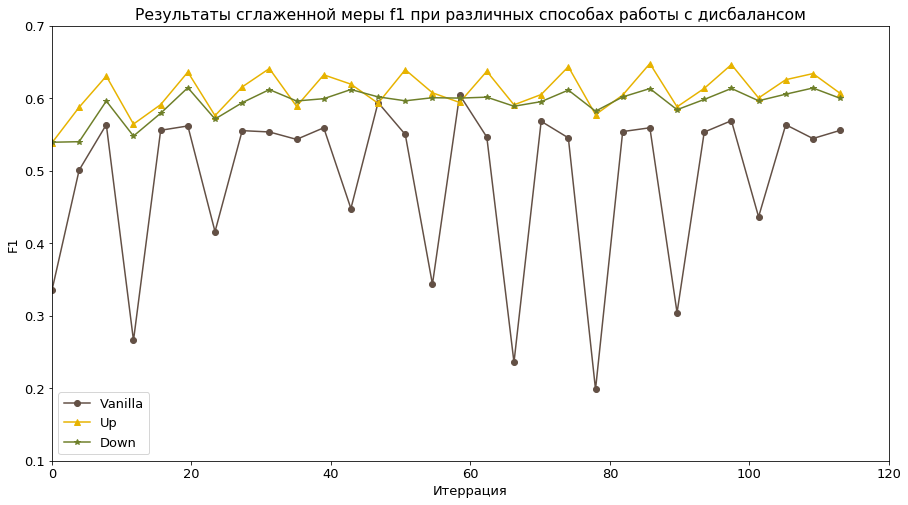

In [151]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize = (15,8))
xnew = np.linspace(data_f1.index.min(), data_f1.index.max(), 30)
spl = make_interp_spline(data_f1.index, data_f1['plain_vanilla'], k = 3)
y_smooth_vanilla = spl(xnew)
spl = make_interp_spline(data_f1.index, data_f1['upsampling'], k = 3)
y_smooth_up = spl(xnew)
spl = make_interp_spline(data_f1.index, data_f1['downsampling'], k = 3)
y_smooth_down = spl(xnew)
plt.plot(xnew, y_smooth_vanilla, color="#635045", marker='o')
plt.plot(xnew, y_smooth_up, color="#e7b300", marker='^')
plt.plot(xnew, y_smooth_down, color="#6e7f29", marker='*')
plt.ylim(0.1, 0.7)
plt.xlim(0.0, 120)
plt.legend(labels = ['Vanilla', 'Up', 'Down'])
plt.title('Результаты сглаженной меры f1 при различных способах работы с дисбалансом')
plt.xlabel('Итеррация')
plt.ylabel('F1')
plt.show()


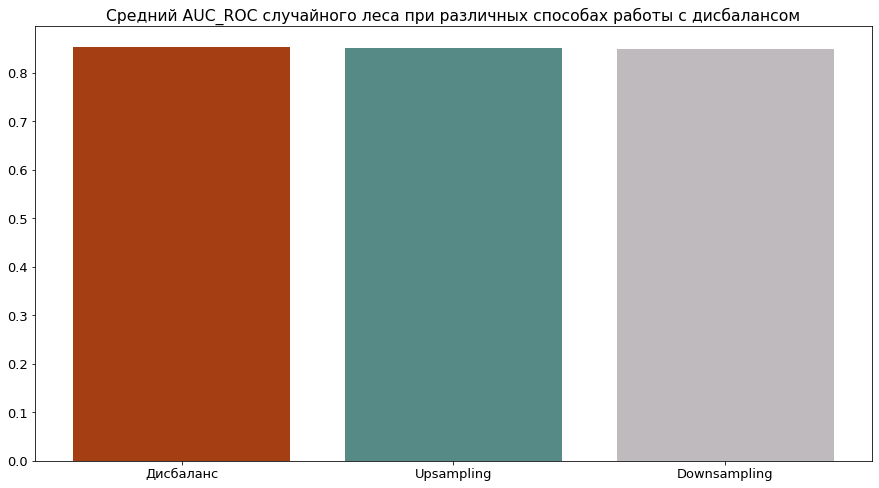

In [152]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize = (15,8))
plt.bar(x = ['Дисбаланс', 'Upsampling', 'Downsampling'], 
        height = [sum(auc_roc_vanilla)/len(auc_roc_vanilla), 
                  sum(auc_roc_upsampling)/len(auc_roc_upsampling), sum(auc_roc_downsampling)/len(auc_roc_downsampling)],
       color = ['#a63e14', '#558a86', '#bfbabe'])
plt.title('Средний AUC_ROC случайного леса при различных способах работы с дисбалансом')
plt.show()

#Из графика еще раз убеждаемся, что увеличение в выборке редкого класса - наиболее результативный способ работы с дисбалансом в проекции увеличения f1 меры. Мера auc_roc ялвляется не чувствительной к этому.

# 4. Тестирование модели

#Так как наилучшие результаты показавала модель случайного леса, то на тестовых данных будем использовать ее, предварительно увеличив выборку.

In [153]:
model = RandomForestClassifier(n_estimators = 95, max_depth = 9, random_state = 12345)
model.fit(features_upsampled, target_upsampled)
valid_predictions = model.predict(test_features)
f1_score(test_target, valid_predictions)

0.5861297539149888

In [154]:
probabilities_valid = model.predict_proba(valid_features)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(valid_target, probabilities_one_valid)
print(auc_roc)

0.8672996154367243


#На тестовых данных также взят барьер в 0.59.На f1-меру можно опираться при проблеме обучения моделей с дисбалансом. После устранения дисабалнса эта метрика растет, а AUC_ROC является к этому не чувствительным. 